# Frequentism and Bayesianism I: a Practical Introduction

**Mario Juric, University of Washington**

**e-mail: <mjuric@astro.washington.edu>, twitter: [@mjuric](http://twitter.com/mjuric)**

---

*This lecture series is almost entirely based on a [post](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) on the blog [Pythonic Perambulations](http://jakevdp.github.io), by [Jake VanderPlas](https://staff.washington.edu/jakevdp/). The content is BSD licensed. See also VanderPlas (2014) ["Frequentism and Bayesianism: A Python-driven Primer"](http://arxiv.org/abs/1411.5018).*

*Slides built using the excellent [RISE](https://github.com/damianavila/RISE) Jupyter extension by [Damian Avila](https://github.com/damianavila).*

<!-- PELICAN_BEGIN_SUMMARY -->

One of the first things a scientist hears about statistics is that there is are two different approaches: ***Frequentism*** and ***Bayesianism***. Despite their importance, many scientific researchers never have opportunity to learn the distinctions between them and the different practical approaches that result.

The purpose of this lecture is to synthesize the philosophical and pragmatic aspects of the frequentist and Bayesian approaches, so that scientists like you might be better prepared to understand the types of data analysis people do.

We'll start by addressing the philosophical distinctions between the views, and from there move to discussion of how these ideas are applied in practice, with some Python code snippets demonstrating the difference between the approaches.

<!-- PELICAN_END_SUMMARY -->

## Prerequisites

* Python Version 2.7
* The "PyData" data science software stack (comes with [Anaconda](https://www.anaconda.com/download/)).


* [emcee](http://dan.iel.fm/emcee/) -- a pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler.
* [AstroML](http://www.astroml.org/) -- a library of statistical and machine learning routines for analyzing, loading, and visualizing astronomical data in Python.

## Frequentism vs. Bayesianism: a Philosophical Debate

<br>
<center>Fundamentally, the disagreement between frequentists and Bayesians concerns the definition (interpretation) of probability.</center>
<br>

### Frequentist Probability

For frequentists, probability only has meaning in terms of **a limiting case of repeated measurements**.

That is, if I measure the photon flux $F$ from a given star (we'll assume for now that the star's flux does not vary with time), then measure it again, then again, and so on, each time I will get a slightly different answer due to the statistical error of my measuring device. In the limit of a large number of measurements, the *frequency* of any given value indicates the probability of measuring that value.

For frequentists **probabilities are fundamentally related to frequencies of events**. This means, for example, that in a strict frequentist view, it is meaningless to talk about the probability of the *true* flux of the star: the true flux is (by definition) a single fixed value, and to talk about a frequency distribution for a fixed value is nonsense.

### Bayesian Probability

For Bayesians, the concept of probability is extended to cover **degrees of certainty about statements**. You can think of it as an **extension of logic** to statements where there's uncertainty.

Say a Bayesian claims to measure the flux $F$ of a star with some probability $P(F)$: that probability can certainly be estimated from frequencies in the limit of a large number of repeated experiments, but this is not fundamental. The probability is a statement of my knowledge of what the measurement reasult will be.

For Bayesians, **probabilities are fundamentally related to our own knowledge about an event**. This means, for example, that in a Bayesian view, we can meaningfully talk about the probability that the *true* flux of a star lies in a given range.

That probability codifies our knowledge of the value based on prior information and/or available data.

The surprising thing is that this arguably subtle difference in philosophy leads, in practice, to vastly different approaches to the statistical analysis of data.  Below I will give a few practical examples of the differences in approach, along with associated Python code to demonstrate the practical aspects of the resulting methods.

## Frequentist and Bayesian Approaches in Practice: Counting Photons

Here we'll take a look at an extremely simple problem, and compare the frequentist and Bayesian approaches to solving it. There's necessarily a bit of mathematical formalism involved, but we won't go into too much depth or discuss too many of the subtleties.

If you want to go deeper, you might consider taking a look at chapters 4-5 of the [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.amazon.com/dp/0691151687/) textbook.

### The Problem: Simple Photon Counts

Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{\rm true}$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $N$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $F_i$ and error $e_i$.

**The question is, given this set of measurements $D = \{F_i,e_i\}$, what is our best estimate of the true flux $F_{\rm true}$?**

#### Aside on measurement errors

We'll make the (reasonable) assumption that errors are Gaussian:
* In a Frequentist perspective, $e_i$ is the standard deviation of the results of a single measurement event in the limit of repetitions of *that event*.
* In the Bayesian perspective, $e_i$ is the standard deviation of the (Gaussian) probability distribution describing our knowledge of that particular measurement given its observed value)

Here we'll use Python to generate some toy data to demonstrate the two approaches to the problem.

Because the measurements are number counts, a Poisson distribution is a good approximation to the measurement process:

In [8]:
# Generating some simple photon count data
import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

Now let's make a simple visualization of the "measured" data:

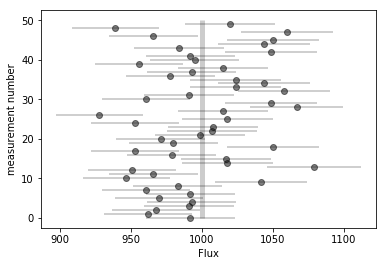

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");

These measurements each have a different error $e_i$ which is estimated from [Poisson statistics](http://en.wikipedia.org/wiki/Poisson_distribution) using the standard square-root rule.

In this toy example we already know the true flux $F_{\rm true}$, but the question is this: **given our measurements and errors, what is our best estimate of the true flux?**

Let's take a look at the frequentist and Bayesian approaches to solving this.

### Frequentist Approach to Simple Photon Counts

We'll start with the classical frequentist **maximum likelihood** approach. Given a single observation $D_i = (F_i, e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{\rm true}$ given our assumption of Gaussian errors:

$$ P(D_i~|~F_{\rm true}) = \frac{1}{\sqrt{2\pi e_i^2}} \exp{\left[\frac{-(F_i - F_{\rm true})^2}{2 e_i^2}\right]} $$

This should be read "the probability of $D_i$ given $F_{\rm true}$ equals ...". You should recognize this as a normal distribution with mean $F_{\rm true}$ and standard deviation $e_i$.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~F_{\rm true}) = \prod_{i=1}^N P(D_i~|~F_{\rm true})$$

Here $D = \{D_i\}$ represents the entire set of measurements. Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood.  Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^N \left[ \log(2\pi  e_i^2) + \frac{(F_i - F_{\rm true})^2}{e_i^2} \right]$$

What we'd like to do is determine $F_{\rm true}$ such that the likelihood is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $d\log\mathcal{L}/dF_{\rm true} = 0$). This results in the following observed estimate of $F_{\rm true}$:

$$ F_{\rm est} = \frac{\sum w_i F_i}{\sum w_i};~~w_i = 1/e_i^2 $$

Notice that in the special case of all errors $e_i$ being equal, this reduces to

$$ F_{\rm est} = \frac{1}{N}\sum_{i=1}^N F_i $$

That is, in agreement with intuition, $F_{\rm est}$ is simply the mean of the observed data when errors are equal.

We can go further and ask what the error of our estimate is? In the frequentist approach, this can be accomplished by fitting a Gaussian approximation to the likelihood curve at maximum; in this simple case this can also be solved analytically.

It can be shown that the standard deviation of this Gaussian approximation is:

$$ \sigma_{\rm est} = \left(\sum_{i=1}^N w_i \right)^{-1/2} $$

These results are fairly simple calculations; let's evaluate them for our toy dataset:

In [10]:
w = 1. / e ** 2
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, (w * F).sum() / w.sum(), w.sum() ** -0.5, N))


      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      


We find that for 50 measurements of the flux, our estimate has an error of about 0.4% and is consistent with the input value.

### Bayesian Approach to Simple Photon Counts

The Bayesian approach, as you might expect, begins and ends with probabilities.  It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$ P(F_{\rm true}~|~D) $$

N.b.: that this formulation of the problem is *fundamentally contrary* to the frequentist philosophy, which says that *probabilities have no meaning for model parameters* like $F_{\rm true}$. Within the ***Bayesian interpretation of probability***, this is perfectly acceptable. 

To compute this result, Bayesians next apply [Bayes' Theorem](http://en.wikipedia.org/wiki/Bayes\'_theorem), a fundamental law of probability:

$$ P(F_{\rm true}~|~D) = \frac{P(D~|~F_{\rm true})~P(F_{\rm true})}{P(D)} $$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian *interpretation of probability* implied by the term $P(F_{\rm true}~|~D)$.

Let's take a look at each of the terms in this expression:

- $P(F_{\rm true}~|~D)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
- $P(D~|~F_{\rm true})$: The **likelihood**, which is proportional to the $\mathcal{L}(D~|~F_{\rm true})$ in the frequentist approach, above.
- $P(F_{\rm true})$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
- $P(D)$: The **data probability**, which in practice amounts to simply a normalization term.

If we set the prior $P(F_{\rm true}) \propto 1$ (a *flat prior*), we find

$$P(F_{\rm true}|D) \propto \mathcal{L}(D|F_{\rm true})$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

### But What About the Prior?

We glossed over something here: the prior, $P(F_{\rm true})$.

The prior ***allows inclusion of other information into the computation***, which becomes very useful in cases where multiple measurement strategies are being combined to constrain a single model (as is the case in, e.g. cosmological parameter estimation).

The necessity to specify a prior, however, is one of the more controversial pieces of Bayesian analysis.

### But What About the Prior?

A frequentist will point out that the ***prior is problematic when no true prior information is available***. Though it might seem straightforward to use a **noninformative prior** like the flat prior mentioned above, there are some [surprisingly subtleties](http://normaldeviate.wordpress.com/2013/07/13/lost-causes-in-statistics-ii-noninformative-priors/comment-page-1/) involved. It turns out that in many situations, a truly noninformative prior does not exist!

***Frequentists point out that the subjective choice of a prior which necessarily biases your result has no place in statistical data analysis***. A Bayesian would counter that frequentism doesn't solve this problem, but simply skirts the question.

Frequentism can often be viewed as simply a special case of the Bayesian approach for some (implicit) choice of the prior: ***a Bayesian would say that it's better to make this implicit choice explicit, even if the choice might include some subjectivity***.

### Photon Counts: the Bayesian approach

Leaving these philosophical debates aside for the time being, let's address how Bayesian results are generally computed in practice.

For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $P(F_{\rm true}~|~D)$ as a function of $F_{\rm true}$: this is the distribution reflecting our knowledge of the parameter $F_{\rm true}$.

But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). Here, we'll be using Dan Foreman-Mackey's excellent [emcee](http://dan.iel.fm/emcee/current/)  package.  Keep in mind here that the goal is to *generate a set of points drawn from the posterior probability distribution*, and to use those points to determine the answer we seek.

To perform this MCMC, we start by defining Python functions for the prior $P(F_{\rm true})$, the likelihood $P(D~|~F_{\rm true})$, and the posterior $P(F_{\rm true}~|~D)$, noting that none of these need be properly normalized. 

Our model here is one-dimensional, but to handle multi-dimensional models we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [F_{\rm true}]$:

In [11]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [12]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

If this all worked correctly, the array ``sample`` should contain a series of 50000 points drawn from the posterior. Let's plot them and check:

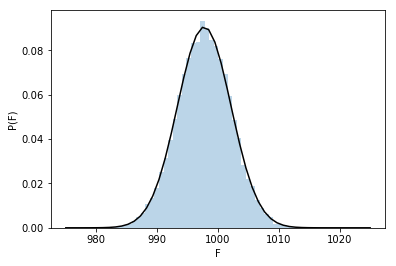

In [13]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")

We end up with a sample of points drawn from the (normal) posterior distribution.  The mean and standard deviation of this posterior are the corollary of the frequentist maximum likelihood estimate above:

In [14]:
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, np.mean(sample), np.std(sample), N))


      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      


We see that as expected for this simple problem, the Bayesian approach yields the same result as the frequentist approach!

### Discussion

Now, you might come away with the impression that the Bayesian method is unnecessarily complicated, and in this case it certainly is. Using an Affine Invariant Markov Chain Monte Carlo Ensemble sampler to characterize a one-dimensional normal distribution is a bit like using the Death Star to destroy a beach ball.

But we did it here because it demonstrates an approach that can scale to complicated posteriors in many, many dimensions, and can provide nice results in more complicated situations where an analytic likelihood approach is not possible.

As a side note, you might also have noticed one little sleight of hand: at the end, we use a frequentist approach to characterize our posterior samples!  When we computed the sample mean and standard deviation above, we were employing a distinctly frequentist technique to characterize the posterior distribution. The pure Bayesian result for a problem like this would be to report the posterior distribution itself (i.e. its representative sample), and leave it at that. That is, in pure Bayesianism the answer to a question is not a single number with error bars; the answer is the posterior distribution over the model parameters!

## Adding a Dimension: Exploring a more sophisticated model

Let's briefly take a look at a more complicated situation, and compare the frequentist and Bayesian results yet again.  Above we assumed that the star was static: now let's assume that we're looking at an object which we suspect has some stochastic variation &mdash; that is, it varies with time, but in an unpredictable way (a Quasar is a good example of such an object).

We'll propose a simple 2-parameter Gaussian model for this object: $\theta = [\mu, \sigma]$ where $\mu$ is the mean value, and $\sigma$ is the standard deviation of the variability *intrinsic to the object*.  Thus our model for the probability of the true flux at the time of each observation looks like this:

$$ F_{\rm true} \sim \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[\frac{-(F - \mu)^2}{2\sigma^2}\right]$$

Now, we'll again consider $N$ observations each with their own error. We can generate them this way:

In [16]:
np.random.seed(42)  # for reproducibility
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above

### Varying Photon Counts: The Frequentist Approach

The resulting likelihood is the convolution of the intrinsic distribution with the error distribution, so we have

$$\mathcal{L}(D~|~\theta) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi(\sigma^2 + e_i^2)}}\exp\left[\frac{-(F_i - \mu)^2}{2(\sigma^2 + e_i^2)}\right]$$

Analogously to above, we can analytically maximize this likelihood to find the best estimate for $\mu$:

$$\mu_{est} =  \frac{\sum w_i F_i}{\sum w_i};~~w_i = \frac{1}{\sigma^2 + e_i^2} $$

And here we have a problem: the optimal value of $\mu$ *depends on* the optimal value of $\sigma$.  The results are correlated, so we can no longer use straightforward analytic methods to arrive at the frequentist result.

Nevertheless, we can use numerical optimization techniques to determine the maximum likelihood value. Here we'll use the optimization routines available within Scipy's [optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html) submodule:

In [17]:
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

# maximize likelihood <--> minimize negative likelihood
def neg_log_likelihood(theta, F, e):
    return -log_likelihood(theta, F, e)

from scipy import optimize
theta_guess = [900, 5]
theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e))
print("""
      Maximum likelihood estimate for {0} data points:
          mu={theta[0]:.0f}, sigma={theta[1]:.0f}
      """.format(N, theta=theta_est))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114

      Maximum likelihood estimate for 100 data points:
          mu=999, sigma=19
      


#### Error Estimates

This maximum likelihood value gives our best estimate of the parameters $\mu$ and $\sigma$ governing our model of the source. But this is only half the answer: we need to determine how confident we are in this answer, that is, we need to compute the error bars on $\mu$ and $\sigma$.

To see how this is done in the frequentist paradigm, see the sub-slides.

There are several approaches to determining errors in a frequentist paradigm.  We could:
* as above, fit a normal approximation to the maximum likelihood and report the covariance matrix (here we'd have to do this numerically rather than analytically).
* Alternatively, we can compute statistics like $\chi^2$ and $\chi^2_{\rm dof}$ to and use standard tests to determine confidence limits, which also depends on strong assumptions about the Gaussianity of the likelihood. 
* We might alternatively use randomized sampling approaches such as "Jackknife"...
* or "Bootstrap", which maximize the likelihood for randomized samples of the input data in order to explore the degree of certainty in the result.

All of these would be valid techniques to use, but each comes with its own assumptions and subtleties.  Here, for simplicity, we'll use the basic bootstrap resampler found in the [astroML][4] package:

[1]: http://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test
[2]: http://en.wikipedia.org/wiki/Jackknife_(statistics)
[3]: http://en.wikipedia.org/wiki/Bootstrapping_(statistics)
[4]: http://astroML.org

In [10]:
from astroML.resample import bootstrap

def fit_samples(sample):
    # sample is an array of size [n_bootstraps, n_samples]
    # compute the maximum likelihood for each bootstrap.
    return np.array([optimize.fmin(neg_log_likelihood, theta_guess,
                                   args=(F, np.sqrt(F)), disp=0)
                     for F in sample])

samples = bootstrap(F, 1000, fit_samples)  # 1000 bootstrap resamplings

Now in a similar manner to what we did above for the MCMC Bayesian posterior, we'll compute the sample mean and standard deviation to determine the errors on the parameters.

In [11]:
mu_samp = samples[:, 0]
sig_samp = abs(samples[:, 1])

print " mu    = {0:.0f} +/- {1:.0f}".format(mu_samp.mean(), mu_samp.std())
print " sigma = {0:.0f} +/- {1:.0f}".format(sig_samp.mean(), sig_samp.std())

 mu    = 999 +/- 4
 sigma = 18 +/- 5


I should note that there is a **huge** literature on the details of bootstrap resampling, and there are definitely some subtleties of the approach that I am glossing over here. One obvious piece is that there is potential for errors to be correlated or non-Gaussian, neither of which is reflected by simply finding the mean and standard deviation of each model parameter. Nevertheless, I trust that this gives the basic idea of the frequentist approach to this problem.

### Varying Photon Counts: The Bayesian Approach

The Bayesian approach to this problem is almost exactly the same as it was in the previous problem, and we can set it up by slightly modifying the above code.

In [20]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

Now that we have the samples, we'll use a convenience routine from astroML to plot the traces and the contours representing one and two standard deviations:

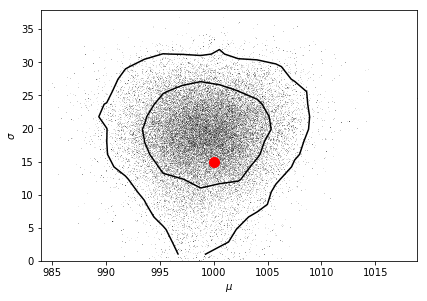

In [21]:
from astroML.plotting import plot_mcmc
fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);

The red dot indicates ground truth (from our problem setup), and the contours indicate one and two standard deviations (68% and 95% confidence levels).  In other words, based on this analysis we are 68% confident that the model lies within the inner contour, and 95% confident that the model lies within the outer contour.

Note here that $\sigma = 0$ is consistent with our data within two standard deviations: that is, depending on the certainty threshold you're interested in, our data are not enough to confidently rule out the possibility of a non-varying source!

***The other thing to notice is that this posterior is definitely *not* Gaussian***: this can be seen by the lack of symmetry in the vertical direction.

That means that the Gaussian approximation used within the frequentist approach may not reflect the true uncertainties in the result.  This isn't an issue with frequentism itself (i.e. there are certainly ways to account for non-Gaussianity within the frequentist paradigm), but the *vast majority* of commonly applied frequentist techniques make the explicit  or implicit assumption of Gaussianity of the distribution.

Bayesian approaches generally don't require such assumptions.

(Side note on priors: there are good arguments that a flat prior on $\sigma$ subtley biases the calculation in this case: i.e. a flat prior is not necessarily non-informative in the case of scale factors like $\sigma$. There are interesting arguments to be made that the [Jeffreys Prior](http://en.wikipedia.org/wiki/Jeffreys_prior) would be more applicable. Here I believe the Jeffreys prior is not suitable, because $\sigma$ is not a true scale factor (i.e. the Gaussian has contributions from $e_i$ as well). On this question, I'll have to defer to others who have more expertise. Note that subtle &mdash; some would say subjective &mdash; questions like this are among the features of Bayesian analysis that frequentists take issue with).

## Conclusion

Philosophical differences underlying frequentism and Bayesianism lead to fundamentally different approaches to simple problems, which nonetheless can often yield similar or even identical results.

***The root of all differences is in a different interpretation of probability***:

- Frequentism considers probabilities to be relative frequencies of a large number of (real or hypothetical) events.
- Bayesianism considers probabilities to measure degrees of knowledge (belief) about something.

... and differences in methodology follow:

- Frequentist analyses generally proceed through use of point estimates and maximum likelihood approaches.
- Bayesian analyses generally compute the posterior either directly or through some version of MCMC sampling.

As we've seen, in simple problems the two approaches can yield similar results.

But as data and models grow in complexity, the two approaches can diverge greatly. We turn to that next...